In [ ]:
import pandas as pd
import numpy as np
from darts.models import LightGBMModel, LinearRegressionModel
from darts.metrics import mae, mape, rmse
from darts import concatenate
import matplotlib.pyplot as plt
import cvxpy as cp
from datetime import timedelta
from tqdm import tqdm
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values
import yfinance as yf

In [ ]:
sp500_list_df = pd.read_csv("sp500_companies.csv")

## Get Top 50 Market Cap

In [29]:
top50_sample = list(sp500_list_df[:50]['Symbol'].values)

In [ ]:
# Example: get daily adjusted close prices for last 5 years
data = yf.download(top50_sample, start="2024-01-01")

print(data.head())

C:\Users\ASUS\AppData\Local\Temp\ipykernel_57140\3108094553.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(top50_sample, start="2024-01-01")
[*********************100%***********************]  50 of 50 completed

Price            Close                                                  \
Ticker            AAPL        ABBV         ABT         ACN        ADBE   
Date                                                                     
2024-01-02  184.081512  150.048782  106.167923  336.625275  580.070007   
2024-01-03  182.703171  150.649643  105.848984  327.892395  571.789978   
2024-01-04  180.382828  151.588486  107.260056  327.087006  567.049988   
2024-01-05  179.658905  152.226929  107.086090  326.630920  564.599976   
2024-01-08  184.002167  151.560318  108.632462  330.250244  580.549988   

Price                                                                  ...  \
Ticker             AMD        AMZN        AVGO         AXP        BAC  ...   
Date                                                                   ...   
2024-01-02  138.580002  149.929993  106.521690  184.565170  32.478317  ...   
2024-01-03  135.320007  148.470001  103.891472  182.614746  32.123829  ...   
2024-01-04  136.0

In [31]:
data.head()

Price            Close                                                  \
Ticker            AAPL        ABBV         ABT         ACN        ADBE   
Date                                                                     
2024-01-02  184.081512  150.048782  106.167923  336.625275  580.070007   
2024-01-03  182.703171  150.649643  105.848984  327.892395  571.789978   
2024-01-04  180.382828  151.588486  107.260056  327.087006  567.049988   
2024-01-05  179.658905  152.226929  107.086090  326.630920  564.599976   
2024-01-08  184.002167  151.560318  108.632462  330.250244  580.549988   

Price                                                                  ...  \
Ticker             AMD        AMZN        AVGO         AXP        BAC  ...   
Date                                                                   ...   
2024-01-02  138.580002  149.929993  106.521690  184.565170  32.478317  ...   
2024-01-03  135.320007  148.470001  103.891472  182.614746  32.123829  ...   
2024-01-04  136.009995  144.570007  102.952255  184.011002  32.382507  ...   
2024-01-05  138.580002  145.240005  102.978760  185.898895  32.986084  ...   
2024-01-08  146.179993  149.100006  105.488258  186.046387  32.727417  ...   

Price         Volume                                                          \
Ticker          PLTR       PM      TMO     TMUS       TSLA      UNH        V   
Date                                                                           
2024-01-02  41626700  5038500  2310800  5049700  104654200  3415700  5471000   
2024-01-03  46865200  4145200  2170300  4608600  121082600  2891400  4148300   
2024-01-04  39937700  5179400  1831300  4068700  102629300  2994400  3843000   
2024-01-05  57700000  3251800  1817200  4552800   92488900  2815400  3748400   
2024-01-08  49090000  3828300  2126800  4135100   85166600  2648900  4659000   

Price                                     
Ticker           WFC       WMT       XOM  
Date                                      
2024-01-02  14916000  23539800  23483000  
2024-01-03  21653600  18756000  23490800  
2024-01-04  15917500  19282500  19395200  
2024-01-05  15074800  21709500  15827400  
2024-01-08  15119700  20680800  23370100  

[5 rows x 250 columns]

In [32]:
data = data.reset_index()

In [33]:
value_cols = []

for col in data.columns:
    if col[0] == 'Close':
        value_cols.append(col)

In [34]:
data['Date'] = pd.to_datetime(data['Date'])

In [ ]:
series_multi = TimeSeries.from_dataframe(data, time_col="Date",
                                         value_cols=value_cols, freq="D")

series_multi = fill_missing_values(series_multi)


initial_window = 30
h = 1  # forecast horizon t+1

model = LightGBMModel(lags=12, verbose=-1)


pred_list = model.historical_forecasts(
    series_multi,
    start=series_multi.time_index[initial_window],
    forecast_horizon=h,
    stride=1,
    retrain=True,
    verbose=False,  
    train_length=30
)

# Concatenate list -> single TimeSeries of predictions
pred = concatenate(pred_list)

# Align actuals and predictions over the same time span
actual = series_multi.slice_intersect(pred)
pred = pred.slice_intersect(actual)

# ── 2) Metrics
val_mae = mae(actual, pred)
val_mape = mape(actual, pred)   # (%) by default
val_rmse = rmse(actual, pred)

print(f"Rolling 1-step forecast metrics (start at day {initial_window}):")
print(f"  MAE  : {val_mae:.6f}")
print(f"  MAPE : {val_mape:.4f}%")
print(f"  RMSE : {val_rmse:.6f}")


pred_df = pred.pd_dataframe().reset_index()

date_sim = data[data['Date'] >= series_multi.time_index[initial_window+30]].Date.values

solutions = []

for date in tqdm(date_sim[:-1]):
    C = data[data['Date'] <= date].sort_index(ascending=False)[value_cols].pct_change().dropna().cov()

    # Number of variables
    n = len(value_cols)

    # The variables vector
    x = cp.Variable(n)

    # The minimum return
    req_return = 0.005

    r0 = data[data['Date'] == date][value_cols].values
    r1 = pred_df[pred_df['time'] == pd.to_datetime(date) + timedelta(days=1)].values[:,1:]

    r = (r1 - r0) / r0
    # The predicted return
    ret = r@x

    # The risk in xT.Q.x format
    risk = cp.quad_form(x, C)

    constraints = [sum(x)==1, ret >= req_return, x >= 0]

    # The core problem definition with the Problem class from CVXPY
    prob = cp.Problem(cp.Minimize(risk), constraints)
    prob.solve(solver='ECOS')

    try:
        sum(x.value)
        solutions.append(x.value)
    except TypeError:
        solutions.append(solutions[-1])

simulated_data = data[data['Date'] >= min(date_sim[:-1])]

realized_returns = []
rows = []

for i, date in enumerate(simulated_data.Date.values[:-1]):
    now = simulated_data.loc[simulated_data['Date'] == date, :]
    next_day = simulated_data.loc[simulated_data['Date'] == pd.to_datetime(date) + timedelta(days=1), :]

    if len(next_day) == 0:
        # if there's no calendar next-day row (e.g., weekend), skip
        continue

    # Per-asset next-day return from prices
    r = (next_day[value_cols].values.squeeze() / now[value_cols].values.squeeze()) - 1.0

    realized_return = float(np.dot(r, solutions[i]))
    realized_returns.append(realized_return)

    row = {"Date": pd.to_datetime(date), "port_ret": realized_return}
    # store per-asset returns and weights for clarity
    for c, rv in zip(value_cols, r):
        row[f"ret_{c}"] = rv
    for c, w in zip(value_cols, solutions[i]):
        row[f"w_{c}"] = w
    rows.append(row)

trades_df = pd.DataFrame(rows).sort_values("Date").reset_index(drop=True)
trades_df["wealth"] = (1.0 + trades_df["port_ret"]).cumprod()
trades_df["cum_return"] = trades_df["wealth"] - 1.0

rf_daily = 0.0
excess = trades_df["port_ret"] - rf_daily
sharpe = (excess.mean() / excess.std(ddof=1)) * np.sqrt(252) if excess.std(ddof=1) != 0 else np.nan

print(f"Annualized Sharpe: {sharpe:.4f}")
    

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


Rolling 1-step forecast metrics (start at day 30):
  MAE  : 8.228491
  MAPE : 2.9320%
  RMSE : 10.920977


 12%|█▏        | 45/387 [00:01<00:11, 30.58it/s]c:\Users\ASUS\anaconda3\envs\maybank\Lib\site-packages\cvxpy\problems\problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 387/387 [00:11<00:00, 32.52it/s]


Annualized Sharpe: 1.7239


In [53]:
pred_df

component,time,"('Close', 'AAPL')","('Close', 'ABBV')","('Close', 'ABT')","('Close', 'ACN')","('Close', 'ADBE')","('Close', 'AMD')","('Close', 'AMZN')","('Close', 'AVGO')","('Close', 'AXP')",...,"('Close', 'PLTR')","('Close', 'PM')","('Close', 'TMO')","('Close', 'TMUS')","('Close', 'TSLA')","('Close', 'UNH')","('Close', 'V')","('Close', 'WFC')","('Close', 'WMT')","('Close', 'XOM')"
0,2024-02-01,188.372257,155.527518,110.165087,355.530913,609.586945,169.538610,156.201387,116.647794,186.260106,...,16.753472,86.510484,545.158580,159.206578,203.067500,493.717924,266.754652,46.782469,53.299282,93.866161
1,2024-02-02,188.487117,155.825033,110.200156,356.437597,611.298055,170.529165,156.500832,117.131362,187.446325,...,16.735972,86.427207,545.659705,159.189785,201.370834,493.009048,267.431824,46.886964,53.421608,94.052781
2,2024-02-03,188.577877,156.191527,110.108976,357.478511,613.373888,171.749443,157.516665,117.737663,188.821415,...,16.760000,86.338203,546.170227,159.126672,199.607223,492.497950,268.101451,47.022241,53.564503,94.246980
3,2024-02-04,188.733778,156.615594,110.011681,358.496206,615.355001,172.737035,158.524998,118.368136,190.202558,...,16.781667,86.235492,546.709110,159.060399,197.702593,491.888321,268.727151,47.157017,53.699572,94.463395
4,2024-02-05,188.975619,157.055633,109.896941,359.446270,617.345001,173.581665,159.586109,119.094261,191.573506,...,16.805556,86.150826,547.396244,158.933812,195.913333,490.837280,269.247347,47.291557,53.842936,94.709607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,2025-09-14,233.959816,212.225368,132.167777,252.659817,351.496760,159.229910,230.582962,325.253430,327.305552,...,159.169259,164.881944,486.828559,248.512621,348.939165,319.920912,346.226013,81.007408,99.867316,112.260742
592,2025-09-15,234.256112,212.769442,132.204999,251.602780,351.024723,158.850281,230.650554,328.721948,327.536109,...,159.978333,164.823056,486.178619,247.952777,352.035831,322.516383,345.605272,80.947778,100.286390,112.235001
593,2025-09-16,234.486112,213.307776,132.202777,250.586112,350.643612,158.438059,230.641109,331.801948,327.551110,...,160.705556,164.593611,485.354133,247.400556,355.594720,325.155004,345.004717,80.916111,100.707501,112.179446
594,2025-09-17,234.820001,213.633331,132.208332,249.299445,350.423057,158.317503,230.921665,335.280280,327.315555,...,161.458333,164.361944,484.713126,246.602222,360.469720,326.924598,344.351939,80.872222,101.065278,112.201113


## Visualize the forecast result

C:\Users\ASUS\AppData\Local\Temp\ipykernel_57140\964365589.py:2: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(pred_df['time'], pred_df["('Close', 'AAPL')"], label="Forecast")


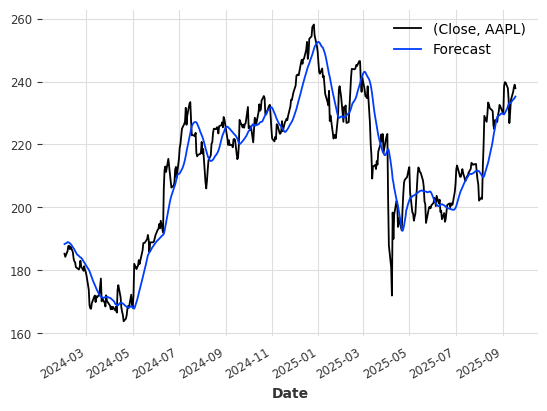

In [74]:
data[data['Date'].isin(pred_df['time'])].plot(x="Date", y=('Close', 'AAPL'))
plt.plot(pred_df['time'], pred_df["('Close', 'AAPL')"], label="Forecast")
plt.legend()
plt.show()

## Create a function to simulate the events

In [ ]:
def simulate(model):
    print(f"MODEL: {model}")
    series_multi = TimeSeries.from_dataframe(data, time_col="Date",
                                            value_cols=value_cols, freq="D")

    series_multi = fill_missing_values(series_multi)


    initial_window = 30
    h = 1  # forecast horizon t+1

    pred_list = model.historical_forecasts(
        series_multi,
        start=series_multi.time_index[initial_window],
        forecast_horizon=h,
        stride=1,
        retrain=True,
        verbose=False,  
        train_length=30
    )

    # Concatenate list -> single TimeSeries of predictions
    pred = concatenate(pred_list)

    # Align actuals and predictions over the same time span
    actual = series_multi.slice_intersect(pred)
    pred = pred.slice_intersect(actual)

    # ── 2) Metrics
    val_mae = mae(actual, pred)
    val_mape = mape(actual, pred)   # (%) by default
    val_rmse = rmse(actual, pred)

    print(f"Rolling 1-step forecast metrics (start at day {initial_window}):")
    print(f"  MAE  : {val_mae:.6f}")
    print(f"  MAPE : {val_mape:.4f}%")
    print(f"  RMSE : {val_rmse:.6f}")


    pred_df = pred.pd_dataframe().reset_index()

    date_sim = data[data['Date'] >= series_multi.time_index[initial_window+30]].Date.values

    solutions = []

    for date in tqdm(date_sim[:-1]):
        C = data[data['Date'] <= date].sort_index(ascending=False)[value_cols].pct_change().dropna().cov()

        # Number of variables
        n = len(value_cols)

        # The variables vector
        x = cp.Variable(n)

        # The minimum return
        req_return = 0.005

        r0 = data[data['Date'] == date][value_cols].values
        r1 = pred_df[pred_df['time'] == pd.to_datetime(date) + timedelta(days=1)].values[:,1:]

        r = (r1 - r0) / r0
        # The predicted return
        ret = r@x

        # The risk in xT.Q.x format
        risk = cp.quad_form(x, C)

        constraints = [sum(x)==1, ret >= req_return, x >= 0]

        # The core problem definition with the Problem class from CVXPY
        prob = cp.Problem(cp.Minimize(risk), constraints)
        prob.solve(solver="ECOS")

        try:
            sum(x.value)
            solutions.append(x.value)
        except TypeError:
            solutions.append(solutions[-1])

    simulated_data = data[data['Date'] >= min(date_sim[:-1])]

    realized_returns = []
    rows = []

    for i, date in enumerate(simulated_data.Date.values[:-1]):
        now = simulated_data.loc[simulated_data['Date'] == date, :]
        next_day = simulated_data.loc[simulated_data['Date'] == pd.to_datetime(date) + timedelta(days=1), :]

        if len(next_day) == 0:
            # if there's no calendar next-day row (e.g., weekend), skip
            continue

        # Per-asset next-day return from prices
        r = (next_day[value_cols].values.squeeze() / now[value_cols].values.squeeze()) - 1.0

        # Multiply the actual returns to the optimized portfolio weights
        realized_return = float(np.dot(r, solutions[i]))
        realized_returns.append(realized_return)

        row = {"Date": pd.to_datetime(date), "port_ret": realized_return}
        # store per-asset returns and weights for clarity
        for c, rv in zip(value_cols, r):
            row[f"ret_{c}"] = rv
        for c, w in zip(value_cols, solutions[i]):
            row[f"w_{c}"] = w
        rows.append(row)

    trades_df = pd.DataFrame(rows).sort_values("Date").reset_index(drop=True)
    trades_df["wealth"] = (1.0 + trades_df["port_ret"]).cumprod()
    trades_df["cum_return"] = trades_df["wealth"] - 1.0

    rf_daily = 0.0
    excess = trades_df["port_ret"] - rf_daily
    sharpe = (excess.mean() / excess.std(ddof=1)) * np.sqrt(252) if excess.std(ddof=1) != 0 else np.nan

    print(f"Annualized Sharpe: {sharpe:.4f}")

In [52]:
models = [
    LightGBMModel(lags=14, verbose=-1),
    LinearRegressionModel(lags=10)
]

for model in models:
    simulate(model)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


MODEL: LGBMRegressor(verbose=-1)
Rolling 1-step forecast metrics (start at day 30):
  MAE  : 7.756198
  MAPE : 2.7678%
  RMSE : 10.361890


100%|██████████| 387/387 [00:17<00:00, 22.19it/s]
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


Annualized Sharpe: 1.6915
MODEL: LinearRegression()
Rolling 1-step forecast metrics (start at day 30):
  MAE  : 3.298151
  MAPE : 1.1711%
  RMSE : 5.164987


100%|██████████| 387/387 [00:12<00:00, 32.16it/s]


Annualized Sharpe: 1.9045


## Using Historical Return As Benchmark

In [ ]:
date_sim = data[data['Date'] >= series_multi.time_index[initial_window+30]].Date.values

solutions = []

for date in tqdm(date_sim[:-1]):
    C = data[data['Date'] <= date].sort_index(ascending=False)[value_cols].pct_change().dropna().cov()

    # Number of variables
    n = len(value_cols)

    # The variables vector
    x = cp.Variable(n)

    # The minimum return
    req_return = 0.005

    #calculate mean of historical returns
    r = data[data['Date'] <= date].sort_index(ascending=False)[value_cols].pct_change().mean().values
    # The predicted return
    ret = r@x

    # The risk in xT.Q.x format
    risk = cp.quad_form(x, C)

    constraints = [sum(x)==1, ret >= req_return, x >= 0]

    # The core problem definition with the Problem class from CVXPY
    prob = cp.Problem(cp.Minimize(risk), constraints)
    prob.solve(solver='ECOS')

    try:
        sum(x.value)
        solutions.append(x.value)
    except TypeError:
        solutions.append(solutions[-1])

simulated_data = data[data['Date'] >= min(date_sim[:-1])]

realized_returns = []
rows = []

for i, date in enumerate(simulated_data.Date.values[:-1]):
    now = simulated_data.loc[simulated_data['Date'] == date, :]
    next_day = simulated_data.loc[simulated_data['Date'] == pd.to_datetime(date) + timedelta(days=1), :]

    if len(next_day) == 0:
        # if there's no calendar next-day row (e.g., weekend), skip
        continue

    # Per-asset next-day return from prices
    r = (next_day[value_cols].values.squeeze() / now[value_cols].values.squeeze()) - 1.0

    realized_return = float(np.dot(r, solutions[i]))
    realized_returns.append(realized_return)

    row = {"Date": pd.to_datetime(date), "port_ret": realized_return}
    # store per-asset returns and weights for clarity
    for c, rv in zip(value_cols, r):
        row[f"ret_{c}"] = rv
    for c, w in zip(value_cols, solutions[i]):
        row[f"w_{c}"] = w
    rows.append(row)

trades_df = pd.DataFrame(rows).sort_values("Date").reset_index(drop=True)
trades_df["wealth"] = (1.0 + trades_df["port_ret"]).cumprod()
trades_df["cum_return"] = trades_df["wealth"] - 1.0

rf_daily = 0.0
excess = trades_df["port_ret"] - rf_daily
sharpe = (excess.mean() / excess.std(ddof=1)) * np.sqrt(252) if excess.std(ddof=1) != 0 else np.nan

print(f"Annualized Sharpe: {sharpe:.4f}")
    

 54%|█████▍    | 210/387 [00:07<00:05, 30.79it/s]c:\Users\ASUS\anaconda3\envs\maybank\Lib\site-packages\cvxpy\problems\problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
 65%|██████▍   | 250/387 [00:08<00:04, 30.41it/s]c:\Users\ASUS\anaconda3\envs\maybank\Lib\site-packages\cvxpy\problems\problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 387/387 [00:13<00:00, 28.86it/s]


Annualized Sharpe: 0.9098
